In [1]:
import numpy as np

from keras.models import load_model

from tweepy.streaming import StreamListener
from tweepy import Stream

import tweets_preprocessor, sentence_cleaner, twitter

import datetime

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

/home/dheer1206/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%time
model = load_model("model_new.h5")

CPU times: user 4.71 s, sys: 575 ms, total: 5.28 s
Wall time: 16.7 s


In [3]:
temp_counter = 0 

In [4]:
def animate(i) :
    
    global mean_list , index_list
    global fig , ax
    
    ax.clear()
    ax.plot( index_list , mean_list )

In [5]:
def tweets_processor_and_graph_plotter( tweet ) :
    
    global temp_counter, start_time , current_index , window , sentiment_list
    global mean_list , index_list
    
    tweet_list = [ tweet.text ]
    
    tweet_list_pad = tweets_preprocessor.preprocess_tweets( tweet_list )
    
    prediction = model.predict( tweet_list_pad )
    
    tweet_time = tweet.created_at
    
    duration = ( tweet_time - start_time ).seconds
    
    if ( int( duration / window ) != current_index ) :
        
        assert( current_index < int( duration / window ) )
        
        current_index = int( duration / window )
        
        mean_sentiment = np.mean( np.array( sentiment_list ) )
        
        #print ("inside " + str(mean_sentiment) + " " + str(current_index) )
        
        mean_list.append( mean_sentiment )
        index_list.append( current_index )
        
        #ani = animation.FuncAnimation( fig , animate , interval = 1000 )
        
        plt.gcf().clear()
        plt.plot( index_list, mean_list )
        plt.show()
        
    else :
        sentiment_list.append( prediction[0] )
        temp_counter += 1 
        if (temp_counter % 10 == 0) :
            with open( 'debug.txt' , 'a' ) as debugger :
                line = "Done " + str(temp_counter) + " tweets in " + str(duration) + " seconds.\n"
                debugger.write( line )
    

In [6]:
class TwitterListener(StreamListener) :
    
    #Basic Listener that just prints tweets to stdout and also saves them to file
    
    def __init( self) :
        pass
    
    def on_status( self , data ) :
        
        try : 
            tweets_processor_and_graph_plotter(data)
        
        except BaseException as e :
            print ("Error on Data : ", str(e))
        
        return True 
    
    def on_error( self , status ) :
        
        #Returning False on_data method if rate limit occurs
        if (status == 420) :
            return False
        if (status == 429) :
            print ("Rate Limit Exceeded")
        
        print (status)

In [7]:
class TwitterStreamer() :
    
    #Class for streaming and processing live tweets
    
    def __init__(self) :
        self.twitter_authenticator = twitter.TwitterAuthenticator() 
    
    def stream_tweets( self , hash_tags_list ) :
        
        listener = TwitterListener( )
        
        auth = self.twitter_authenticator.authenticate_twitter_app()
        
        stream = Stream( auth , listener ) 
        
        #Filtering tweets according to out hash tags list
        stream.filter( track = hash_tags_list , languages=["en"]  )
        

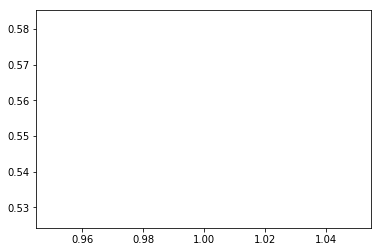

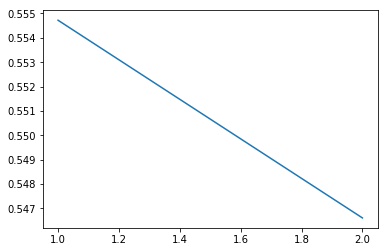

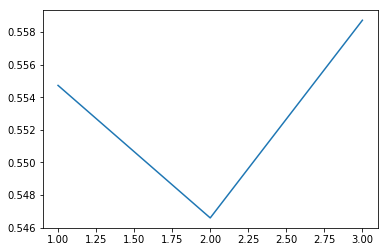

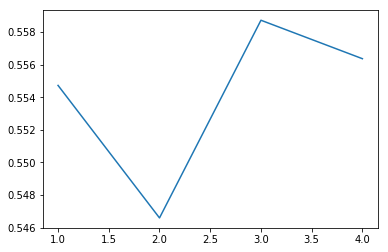

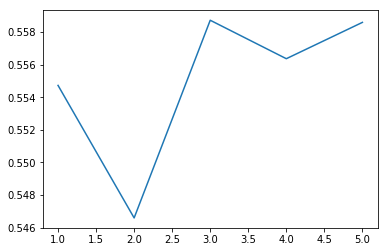

ReadTimeoutError: HTTPSConnectionPool(host='stream.twitter.com', port=443): Read timed out.

In [8]:
hash_tags_list = ['bitcoin']

#Initial Variables
start_time = datetime.datetime.utcnow()
current_index = 0
window = 30
sentiment_list = []

mean_list = []
index_list = []


twitter_streamer = TwitterStreamer() 

twitter_streamer.stream_tweets( hash_tags_list )